# Neural Style Transfer

In [20]:
## importing modules

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import PIL.Image
from tqdm import tqdm
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import functools
import IPython.display as display

In [21]:
## the image is going to be a tf variable
## so we need a function to convert it back to an image
def tensor_to_image(tensor):
    # tensor images are normalized so denormalize them
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)
    

In [22]:
# 
def load_img(path_to_img):
    max_dim = 512
    # read file
    img = tf.io.read_file(path_to_img)
    # decode with three channels RGB
    img = tf.image.decode_image(img, channels=3)
    # convert the datatype of tensor to float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    # get the size of the image as float32
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    # get the longer dimension
    long_dim = max(shape)
    # define a scaling factor
    scale = max_dim / long_dim
    # scale the image by that factor and save the new shape as int32
    # this keeps the aspect ratio
    new_shape = tf.cast(shape * scale, tf.int32)
    # resize the image to the new shape
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [23]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    
    if title:
        plt.title(title)

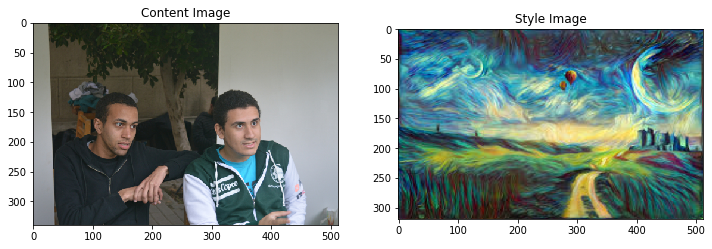

In [24]:
content_path = "images/content.jpg"
style_path = "images/style2.jpg"

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

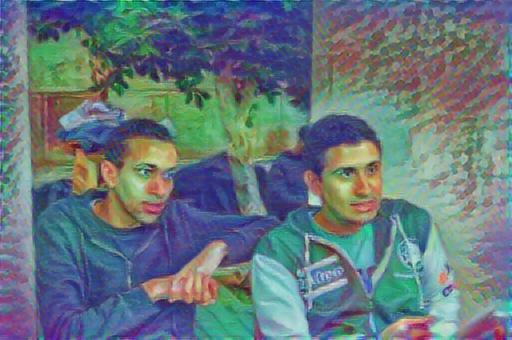

In [25]:
# trying tensorflow_hub ready to go models
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

Real fun starts here
let's load the vgg19 model

In [26]:
# load the vgg19 model without the final prediction layer
# with the weights trained on the imagenet data set
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
# now let's take a look at the architecture of the model
for layer in vgg.layers:
    print(layer.name)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [27]:
# calculating the content cost based on this layer's tensor
content_layers = ['block5_conv2'] 

# calculating the style cost based on these layers' tensors
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


In [28]:
def create_nst_model(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data, lock all layers weights
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    # output for content and style
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [29]:
# create a model with style layers output only
style_extractor = create_nst_model(style_layers)
# calculate style image outputs
style_outputs = style_extractor(style_image*255)

In [30]:
# def gram_matrix(input_tensor):
#     result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
#     input_shape = tf.shape(input_tensor)
#     num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
#     return result/(num_locations)

def gram_matrix(input_tensor):
    input_shape = tf.shape(input_tensor)
    unrolled = tf.reshape(input_tensor, [input_shape[3], input_shape[1] * input_shape[2]])
    result = tf.matmul(unrolled, unrolled, transpose_b=True)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result/(num_locations)

In [31]:
# Model class
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        # create a model from the given layers (content and style)
        self.vgg =  create_nst_model(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        # use vgg19 preprocessing to preprocess the image
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        
        # get the outputs which are 6 outputs five for style and one for content in this case
        outputs = self.vgg(preprocessed_input)
        # the following slicing falls from how we defined the layers in the __init__
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        # calculate gram matrix for style outputs only
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]
        
        # create a dictionary for content {layer_name: layer_output}
        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        # create a dictionary for style {layer_name: layer_output}
        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [32]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image)) # {content: content_dict, style: style_dict}

In [33]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [34]:
# create a tf variable from the content image
# this will be manipulated later by the optimizer
image = tf.Variable(content_image)

In [35]:
# make sure the values don't exceed 1
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [36]:
# define the optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [37]:
# beta
style_weight=1e-2
# alpha
content_weight=1e4

In [38]:
def style_content_loss(outputs):
    """
    computes the total loss J = alpha * J_c + beta * J_s
    :param outputs: the output dictionary containing the style outputs and the content outputs
    """
    style_outputs = outputs['style'] # get style outputs
    content_outputs = outputs['content'] # get content output
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [39]:
@tf.function()
def train_step(image):
    # this context manager is used to calculate the gradient
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


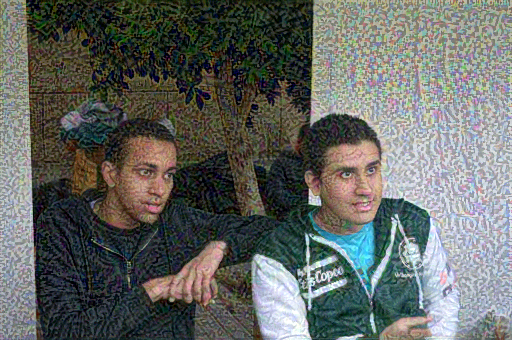

In [40]:
for i in tqdm(range(50)):
    train_step(image)
tensor_to_image(image)